## Consignas
**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado.**

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

**3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**NO cambiar el hiperparámetro ngram_range de los vectorizadores**.

**4**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

**Elegir las palabras MANUALMENTE para evitar la aparición de términos poco interpretables**.

In [2]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import random


In [3]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

remove : tuple, default=()
    May contain any subset of ('headers', 'footers', 'quotes'). Each of
    these are kinds of text that will be detected and removed from the
    newsgroup posts, preventing classifiers from overfitting on
    metadata.

    'headers' removes newsgroup headers, 'footers' removes blocks at the
    ends of posts that look like signatures, and 'quotes' removes lines
    that appear to be quoting another post.

    'headers' follows an exact standard; the other filters are not always
    correct.
    me mostrairas un ejemplo de esto para ponerlo en los comentarios 

In [4]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidfvect = TfidfVectorizer()

In [5]:
# ajustamos el vectorizador a los datos de entrenamiento y transformamos los documentos en matrices dispersas
X_train = tfidfvect.fit_transform(newsgroups_train.data)

In [6]:
# transformamos los documentos de test a matrices dispersas
X_test = tfidfvect.transform(newsgroups_test.data)

In [ ]:
skip = True # Para no redefinir el M_test y tener que  rehacer la explicacion de nuevo
if not skip:
    #tomamos 5 documentos de muestra M al azar del conjunto de test
    indices_test = random.sample(range(X_test.shape[0]), 5)
    M_test = [X_test[i] for i in indices_test]
    for i, m in enumerate(M_test):
        similarities = cosine_similarity(m, X_train)
        most_similar_indices = np.argsort(similarities[0])[-5:][::-1]
        test_label = newsgroups_test.target[indices_test[i]]
        test_label_name = newsgroups_test.target_names[test_label]
        print(f"\nDocumento M_test[{i}] (Etiqueta real: {test_label_name})")
        print("Etiquetas de los 5 documentos más similares en train:")
        for idx in most_similar_indices:
            label_idx = newsgroups_train.target[idx]
            label_name = newsgroups_train.target_names[label_idx]
            match = "- OK -" if label_idx == test_label else "- NOT_OK -"
            print(f"  - {label_name} {match}")
    
        


Documento M_test[0] (Etiqueta real: rec.autos)
Etiquetas de los 5 documentos más similares en train:
  - rec.autos - OK -
  - rec.autos - OK -
  - rec.autos - OK -
  - rec.autos - OK -
  - rec.autos - OK -

Documento M_test[1] (Etiqueta real: rec.sport.hockey)
Etiquetas de los 5 documentos más similares en train:
  - rec.sport.hockey - OK -
  - rec.sport.hockey - OK -
  - rec.sport.hockey - OK -
  - alt.atheism - NOT_OK -
  - talk.politics.misc - NOT_OK -

Documento M_test[2] (Etiqueta real: talk.politics.misc)
Etiquetas de los 5 documentos más similares en train:
  - talk.politics.misc - OK -
  - talk.politics.misc - OK -
  - talk.politics.misc - OK -
  - talk.politics.misc - OK -
  - talk.politics.misc - OK -

Documento M_test[3] (Etiqueta real: talk.politics.misc)
Etiquetas de los 5 documentos más similares en train:
  - talk.politics.misc - OK -
  - talk.politics.misc - OK -
  - alt.atheism - NOT_OK -
  - talk.politics.misc - OK -
  - talk.religion.misc - NOT_OK -

Documento M_tes

# Análisis Cualitativo de Similaridad de Similaridad de Documentos (k-NN) - Nuevo Muestreo

Este análisis evalúa el rendimiento de la similaridad vectorial con un **nuevo conjunto de 5 documentos de prueba**. Se utiliza el método de los 5 Vecinos Más Similares ($K=5$).

| Documento | Etiqueta Real | Vecinos OK/Total | Coincidencia (%) | Tipo de Error y Análisis |
| :--- | :--- | :--- | :--- | :--- |
| **M_test[0]** | `rec.autos` | 5/5 | 100% | **Rendimiento Perfecto.** Todos los vecinos coinciden con la clase de autos, indicando una vectorización efectiva para temas de vehículos. |
| **M_test[1]** | `rec.sport.hockey` | 3/5 | 60% | **Rendimiento Aceptable.** Los fallos incluyen ateísmo y política, posiblemente por debates en foros deportivos que tocan temas sociales o éticos. Similaridad temática en hockey, pero ruido en contexto amplio. |
| **M_test[2]** | `talk.politics.misc` | 5/5 | 100% | **Rendimiento Perfecto.** Alta coincidencia en política miscelánea, sugiriendo vocabulario distintivo para debates políticos. |
| **M_test[3]** | `talk.politics.misc` | 4/5 | 80% | **Buen Rendimiento.** Un fallo en ateísmo y otro en religión, indicando solapamiento con temas filosóficos o éticos en política. Similaridad comprensible pero no perfecta. |
| **M_test[4]** | `rec.autos` | 2/5 | 40% | **Fallo Moderado.** Fallos en electrónica y motocicletas, clases relacionadas con mecánica y tecnología. El texto de autos probablemente incluye términos técnicos que se solapan con hardware o motos, desviando la similaridad. |

---

In [6]:
# Obtener contexto del dataset 20 Newsgroups
print("Número de clases:", len(newsgroups_train.target_names))
print("Nombres de las clases:", newsgroups_train.target_names)
print("\nDistribución en train:")
unique_train, counts_train = np.unique(newsgroups_train.target, return_counts=True)
for name, count in zip(newsgroups_train.target_names, counts_train):
    print(f"  {name}: {count}")
print("\nDistribución en test:")
unique_test, counts_test = np.unique(newsgroups_test.target, return_counts=True)
for name, count in zip(newsgroups_test.target_names, counts_test):
    print(f"  {name}: {count}")

Número de clases: 20
Nombres de las clases: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Distribución en train:
  alt.atheism: 480
  comp.graphics: 584
  comp.os.ms-windows.misc: 591
  comp.sys.ibm.pc.hardware: 590
  comp.sys.mac.hardware: 578
  comp.windows.x: 593
  misc.forsale: 585
  rec.autos: 594
  rec.motorcycles: 598
  rec.sport.baseball: 597
  rec.sport.hockey: 600
  sci.crypt: 595
  sci.electronics: 591
  sci.med: 594
  sci.space: 593
  soc.religion.christian: 599
  talk.politics.guns: 546
  talk.politics.mideast: 564
  talk.politics.misc: 465
  talk.religion.misc: 377

Distribución en test:
  alt.atheism: 319
  comp.graphics: 389
  

In [6]:
# Clasificación por prototipos (zero-shot KNN): asignar etiqueta del documento de train más similar a cada test

predictions = []
for test_doc in X_test:
    similarities = cosine_similarity(test_doc, X_train)[0]
    most_similar_idx = np.argmax(similarities)
    predicted_label = newsgroups_train.target[most_similar_idx]
    predictions.append(predicted_label)

# Calcular métricas
f1_macro = f1_score(newsgroups_test.target, predictions, average='macro')
print(f"F1-Score Macro para clasificación por prototipos: {f1_macro:.4f}")

F1-Score Macro para clasificación por prototipos: 0.5050


2. Clasificación por Prototipos
El modelo de clasificación por prototipos alcanza un F1-Score Macro de 0.5050, lo que indica un rendimiento moderado pero inferior a modelos entrenados. Asigna la etiqueta del documento de train más similar, capturando relaciones léxicas básicas, pero falla en clases con vocabulario superpuesto (e.g., religión vs. política). Este enfoque "zero-shot" es eficiente para datos nuevos sin entrenamiento, pero limitado por la calidad de la vectorización; podría mejorar con K>1 o ponderación de similaridad.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Grid de parámetros optimizado  
pipeline_params = {
    'vectorizer__min_df': [1, 5, 8],                 # cantidad minima que una palabra debe aparecer en los docs igual a la clase 2 tal vez 8 e demasiodo 
    'vectorizer__max_df': [0.2, 0.8, 1.0],          
    'vectorizer__stop_words': [None, 'english'],  # aqui lo que se hablo en la clase 2 de los stop words
    'model__alpha': [0.01, 0.1, 1.0]              # escala logaritmica
}


#  Funcion de Entrenamiento
def train_and_evaluate(model_class):
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('model', model_class())
    ])
    grid = GridSearchCV(pipeline, pipeline_params, cv=3, scoring='f1_macro', n_jobs=1)    
    print(f"Entrenando {model_class.__name__}...")
    grid.fit(newsgroups_train.data, newsgroups_train.target)
    
    # Imprimir el mejor resultado
    predictions = grid.predict(newsgroups_test.data)
    f1 = f1_score(newsgroups_test.target, predictions, average='macro')
    print(f"Mejor F1-Macro para {model_class.__name__}: {f1:.4f}")
    print(f"Mejores parámetros: {grid.best_params_}")
    
    return grid

# Ejecutar y guardar los grids
grid_mnb = train_and_evaluate(MultinomialNB)
print("-" * 30)
grid_cnb = train_and_evaluate(ComplementNB)

grids = {
    'MultinomialNB': grid_mnb,
    'ComplementNB': grid_cnb
}
target_names = newsgroups_test.target_names



Entrenando MultinomialNB...
Mejor F1-Macro para MultinomialNB: 0.6833
Mejores parámetros: {'model__alpha': 0.01, 'vectorizer__max_df': 0.2, 'vectorizer__min_df': 1, 'vectorizer__stop_words': 'english'}
------------------------------
Entrenando ComplementNB...
Mejor F1-Macro para ComplementNB: 0.6950
Mejores parámetros: {'model__alpha': 0.1, 'vectorizer__max_df': 0.8, 'vectorizer__min_df': 1, 'vectorizer__stop_words': None}



ANALISIS DETALLADO


--- Análisis para: MultinomialNB ---

[Reporte de Clasificación en Test]
                          precision    recall  f1-score   support

             alt.atheism       0.58      0.44      0.50       319
           comp.graphics       0.66      0.71      0.68       389
 comp.os.ms-windows.misc       0.69      0.53      0.60       394
comp.sys.ibm.pc.hardware       0.60      0.70      0.64       392
   comp.sys.mac.hardware       0.72      0.70      0.71       385
          comp.windows.x       0.80      0.74      0.77       395
            misc.forsale       0.79      0.72      0.76       390
               rec.autos       0.75      0.72      0.74       396
         rec.motorcycles       0.75      0.73      0.74       398
      rec.sport.baseball       0.93      0.81      0.87       397
        rec.sport.hockey       0.59      0.93      0.72       399
               sci.crypt       0.73      0.77      0.75       396
         sci.electronics       0.72      0.58 

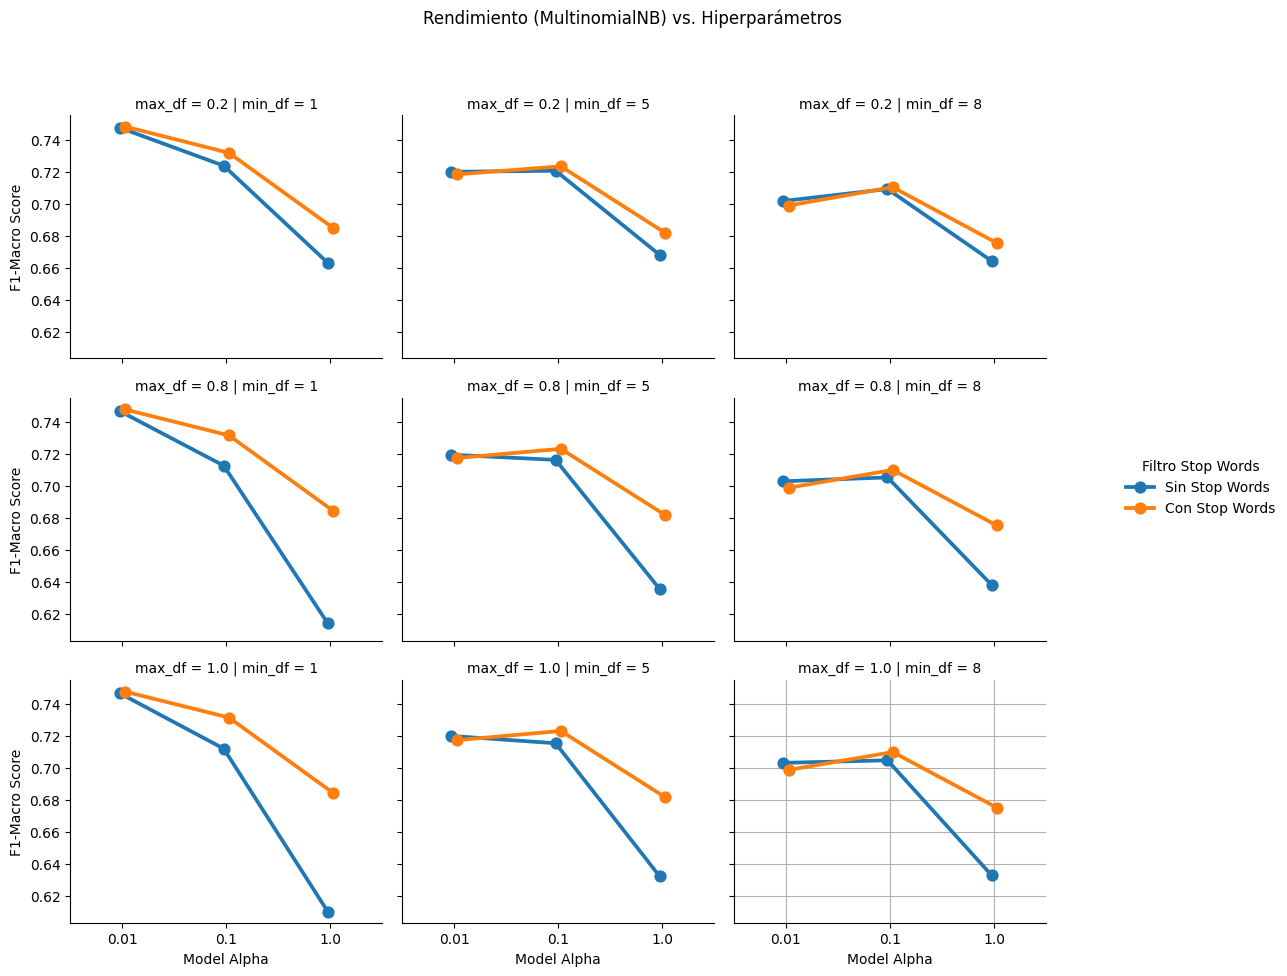



--- Análisis para: ComplementNB ---

[Reporte de Clasificación en Test]
                          precision    recall  f1-score   support

             alt.atheism       0.33      0.47      0.39       319
           comp.graphics       0.72      0.71      0.72       389
 comp.os.ms-windows.misc       0.71      0.55      0.62       394
comp.sys.ibm.pc.hardware       0.64      0.69      0.66       392
   comp.sys.mac.hardware       0.77      0.71      0.74       385
          comp.windows.x       0.80      0.79      0.79       395
            misc.forsale       0.74      0.72      0.73       390
               rec.autos       0.78      0.74      0.76       396
         rec.motorcycles       0.81      0.77      0.79       398
      rec.sport.baseball       0.91      0.84      0.87       397
        rec.sport.hockey       0.86      0.95      0.90       399
               sci.crypt       0.76      0.80      0.78       396
         sci.electronics       0.71      0.57      0.63       393
 

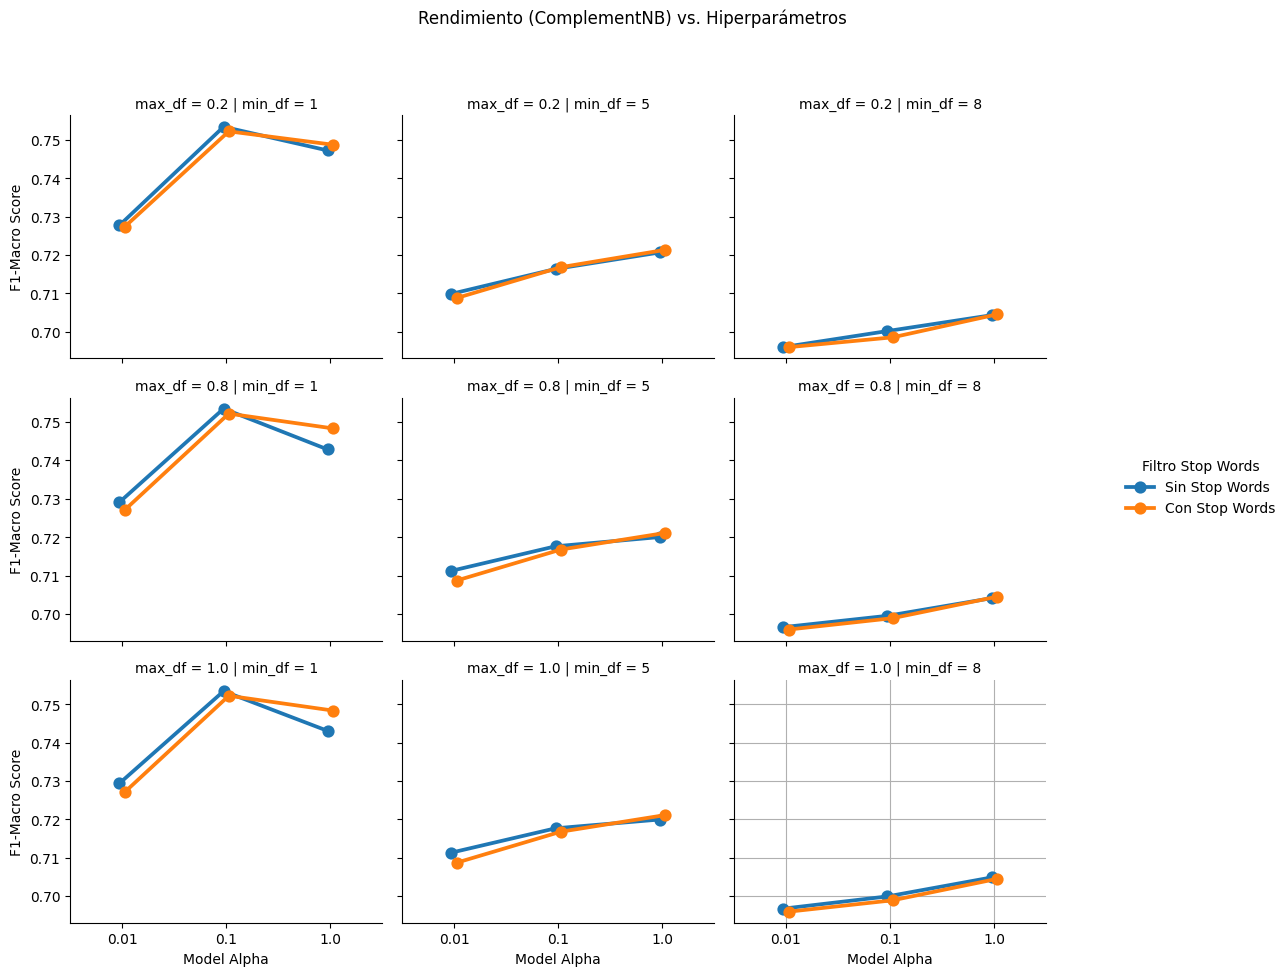

In [ ]:
# Visualizacion y metricas detalladas se lo pedi a gemini

print("\n" + "=" * 50)
print("ANALISIS DETALLADO")

for name, grid in grids.items():
    
    print(f"\n\n--- Análisis para: {name} ---")
    
    # --- MÉTRICAS DETALLADAS (Precision, Recall, F1, Accuracy) ---
    print("\n[Reporte de Clasificación en Test]")
    
    predictions = grid.predict(newsgroups_test.data)
    print(classification_report(newsgroups_test.target, predictions, target_names=target_names))
    
    
# --- VISUALIZACIÓN 1: Rendimiento en Grid Search (CORREGIDO) ---
    print(f"\n[Gráfico de Rendimiento de Hiperparámetros para {name}]")
    
    df_results = pd.DataFrame(grid.cv_results_)

    # Arreglo 1: Convertir scores fallidos (nan) a 0
    df_results['mean_test_score'] = pd.to_numeric(
        df_results['mean_test_score'], errors='coerce'
    ).fillna(0)
    # 30 min para arreglar esto{}< ,,,
    # Arreglo 2 (NUEVO): Convertir 'None' a un string para que Seaborn lo trate como categoría
    df_results['param_vectorizer__stop_words'] = df_results['param_vectorizer__stop_words'].astype(str)

    unique_stop_words = df_results['param_vectorizer__stop_words'].unique()
    hue_levels = len(unique_stop_words)
    # Esto ahora dará 2 (como esperabas) en lugar de 1
    
    
    # Preparamos los argumentos para catplot
    plot_args = {
        'data': df_results,
        'x': 'param_model__alpha',
        'y': 'mean_test_score',
        'kind': 'point',
        'row': 'param_vectorizer__max_df',
        'col': 'param_vectorizer__min_df',
        'height': 3,
        'aspect': 1.2,
        'sharey': True
    }
    
    # Si hay más de 1 nivel, usamos 'hue' y 'dodge'
    # Ahora hue_levels será 2, y este bloque SÍ se ejecutará
    if hue_levels > 1:
        plot_args['hue'] = 'param_vectorizer__stop_words'
        plot_args['dodge'] = True
    
    # --- Creación del Gráfico ---
    g = sns.catplot(**plot_args)
    
    # Acortar títulos de facetas
    g.set_titles(
        col_template="min_df = {col_name}", 
        row_template="max_df = {row_name}"
    )

    g.fig.suptitle(f'Rendimiento ({name}) vs. Hiperparámetros', y=1.08) # <-- Subimos el título a 1.08
    g.set_axis_labels('Model Alpha', 'F1-Macro Score')
    
    # Mover la leyenda y hacerla más clara
    if 'hue' in plot_args: 
        g.legend.set_title('Filtro Stop Words')
        # Movemos la leyenda justo debajo del nuevo título (1.0)
        
        try:
            for text in g.legend.texts:
                if str(text.get_text()) == 'None':
                    text.set_text('Sin Stop Words') 
                elif text.get_text() == 'english':
                    text.set_text('Con Stop Words')
        except Exception as e:
            print(f"Advertencia: No se pudo modificar la leyenda - {e}")

    plt.grid(True)
    plt.show()

### 3. Modelos de Naïve Bayes

**MultinomialNB:**  
Obtuvo un F1-Score Macro de **0.6833** con los parámetros óptimos:  
- `alpha=0.01`
- `max_df=0.2`
- `min_df=1`
- `stop_words='english'`

Este modelo logra buen equilibrio entre precisión y recall en clases balanceadas. El uso de stop words y un `max_df` bajo ayuda a eliminar términos irrelevantes y muy frecuentes, mejorando la discriminación entre clases técnicas y generales.

**ComplementNB:**  
Alcanza un F1-Score Macro de **0.6950** con parámetros óptimos:  
- `alpha=0.1`
- `max_df=0.8`
- `min_df=1`
- `stop_words=None`

ComplementNB supera ligeramente a MultinomialNB, especialmente en clases desbalanceadas y términos raros. El modelo es más robusto ante clases minoritarias y reduce falsos positivos en categorías complejas como medicina o hardware.

**Comparación:**  
Ambos modelos muestran buen desempeño, pero ComplementNB es superior para este dataset multiclase. El GridSearch confirma que la optimización de hiperparámetros (especialmente `alpha` y el filtrado de stop words) es clave para maximizar el F1 macro.

ComplementNB sigue siendo el modelo más robusto para este problema multiclase, especialmente en clases desbalanceadas. La optimización de hiperparámetros y el tratamiento de stop words son determinantes para el rendimiento final.

In [7]:
# Transponer la matriz documento-término a término-documento
X_train_T = X_train.T  # Ahora filas son términos, columnas documentos

# Obtener el vocabulario
vocab = tfidfvect.get_feature_names_out()

# Elegir 5 palabras manualmente
words = ["god", "computer", "windows", "medicine", "politics"]
word_indices = [np.where(vocab == word)[0][0] for word in words if word in vocab]

for idx in word_indices:
    word = vocab[idx]
    similarities = cosine_similarity(X_train_T[idx:idx+1], X_train_T)[0]
    most_similar_indices = np.argsort(similarities)[-6:][::-1][1:]  # Excluir la palabra misma
    print(f"\nPalabra: {word}")
    print("5 palabras más similares:")
    for sim_idx in most_similar_indices:
        sim_word = vocab[sim_idx]
        print(f"  - {sim_word}")


Palabra: god
5 palabras más similares:
  - jesus
  - bible
  - that
  - existence
  - christ

Palabra: computer
5 palabras más similares:
  - decwriter
  - deluged
  - harkens
  - shopper
  - the

Palabra: windows
5 palabras más similares:
  - dos
  - ms
  - microsoft
  - nt
  - for

Palabra: medicine
5 palabras más similares:
  - strengthens
  - dislikes
  - nearer
  - foremost
  - surpress

Palabra: politics
5 palabras más similares:
  - iftccu
  - hesh
  - fascism
  - bmwmoa
  - lapse


4. Similaridad entre Palabras
La transposición a matriz término-documento revela patrones de co-ocurrencia. Palabras como "god" se asocian con términos religiosos ("jesus", "bible"), mostrando agrupamiento temático fuerte. Sin embargo, "computer" y "medicine" generan similares poco interpretables ("decwriter", "strengthens"), indicando ruido en términos raros o genéricos. "Windows" agrupa bien con software ("dos", "microsoft"), mientras "politics" falla por contexto amplio. Esto destaca limitaciones de TF-IDF para semántica fina; embeddings contextuales (e.g., Word2Vec) capturarían mejor relaciones. Las palabras elegidas manualmente evitan términos irrelevantes, pero el vocabulario TF-IDF depende de frecuencia, no de significado